![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Finance/10.Visual_Document_Classification_V3.ipynb)

# **`Visual Document Classifier v3`**

## Install spark-ocr python packge

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()
os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION


# Installing Spark OCR
%pip install spark-ocr==$OCR_VERSION\+spark32 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [25]:
import sys
import base64
import sparkocr


from sparkocr import start
from sparkocr.transformers import *
from pyspark import SparkConf
from sparkocr.enums import *
from sparkocr.utils import display_images, to_pil_image, display_image


from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as f


## Start spark session

In [6]:
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)
spark

Spark version: 3.2.1
Spark NLP version: 4.0.0
Spark OCR version: 4.0.0



## **Classify Visual Finance Documents**

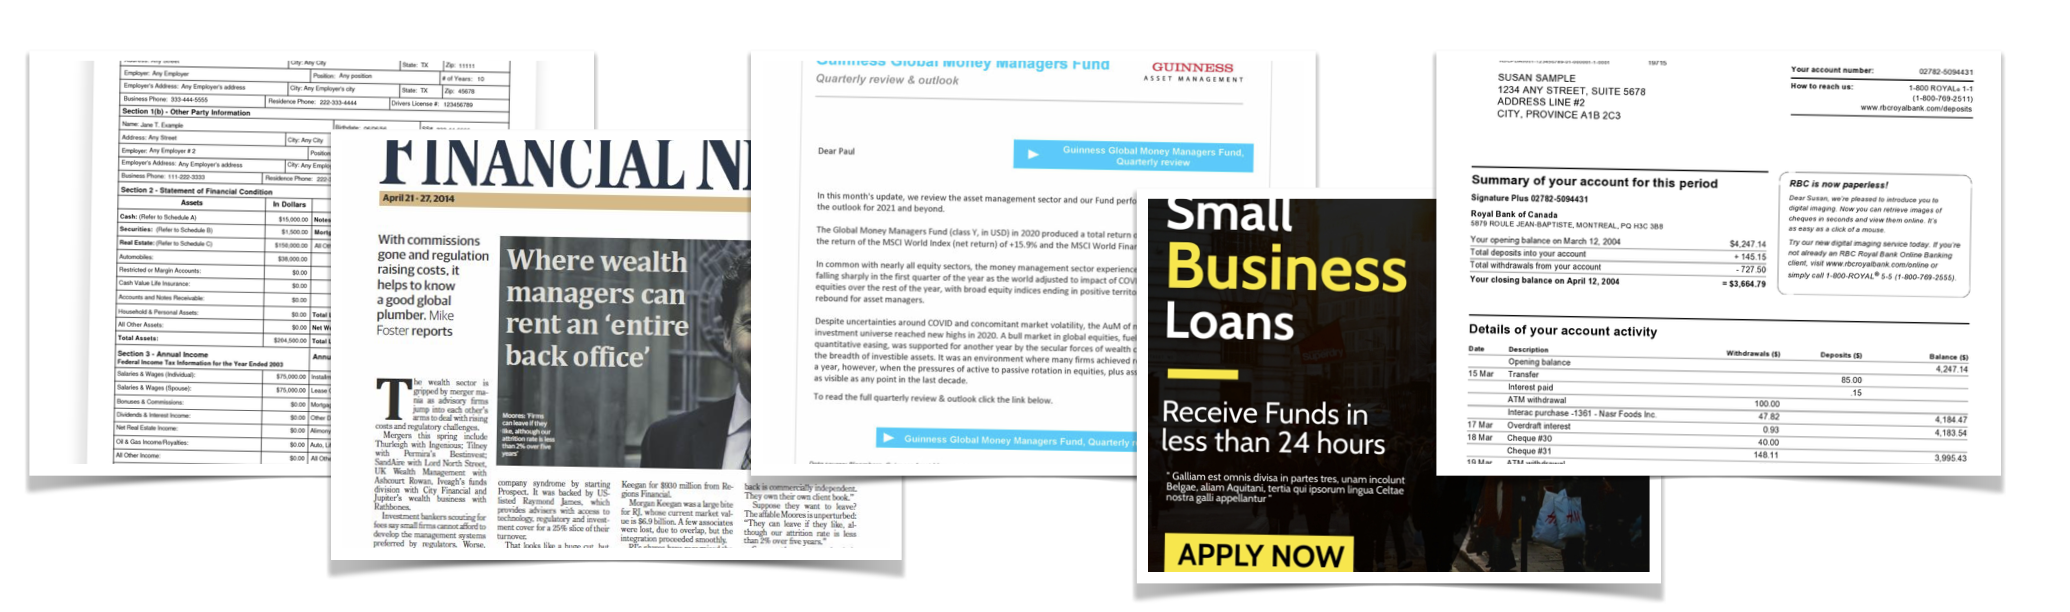

🔎 Document Image Transformer (DiT) model for document classification. The model was pretrained on IIT-CDIP dataset that includes 42 million document images and finetuned on RVL-CDIP dataset that consists of 400 000 grayscale images in 16 classes.

🔎With this model, you can classify financial documents using text and layout data with new features offered by Spark OCR.

🔎Classes detected by the model:

* `letter` 
* `form` 
* `email` 
* `handwritten`
* `advertisement` 
* `scientific report`
* `scientific publicatio`
* `specification`
* `file folder`
* `news article`
* `budget`
* `invoice`
* `presentation`
* `questionnaire`
* `resume` 
* `memo`




## Load test images

In [7]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/visual_document_sample_images/Document_advertisement2.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/visual_document_sample_images/Document_invoice3.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/visual_document_sample_images/Document_advertisement3.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/visual_document_sample_images/Document_budget3.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/visual_document_sample_images/Document_email.png

In [16]:
sample_images = spark.read.format("binaryFile").load("*.png").cache()
sample_images.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/content/Doc...|2022-09-13 07:06:...|1364836|[89 50 4E 47 0D 0...|
|file:/content/Doc...|2022-09-13 07:06:...| 305933|[FF D8 FF E0 00 1...|
|file:/content/Doc...|2022-09-13 07:06:...| 239989|[FF D8 FF E0 00 1...|
|file:/content/Doc...|2022-09-13 07:12:...|  93146|[FF D8 FF E0 00 1...|
|file:/content/Doc...|2022-09-13 07:11:...|  53850|[89 50 4E 47 0D 0...|
+--------------------+--------------------+-------+--------------------+



# Display images


    Image #0:
    Origin: file:/content/Document_invoice3.png
    Resolution: 0 dpi
    Width: 1920 px
    Height: 2889 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


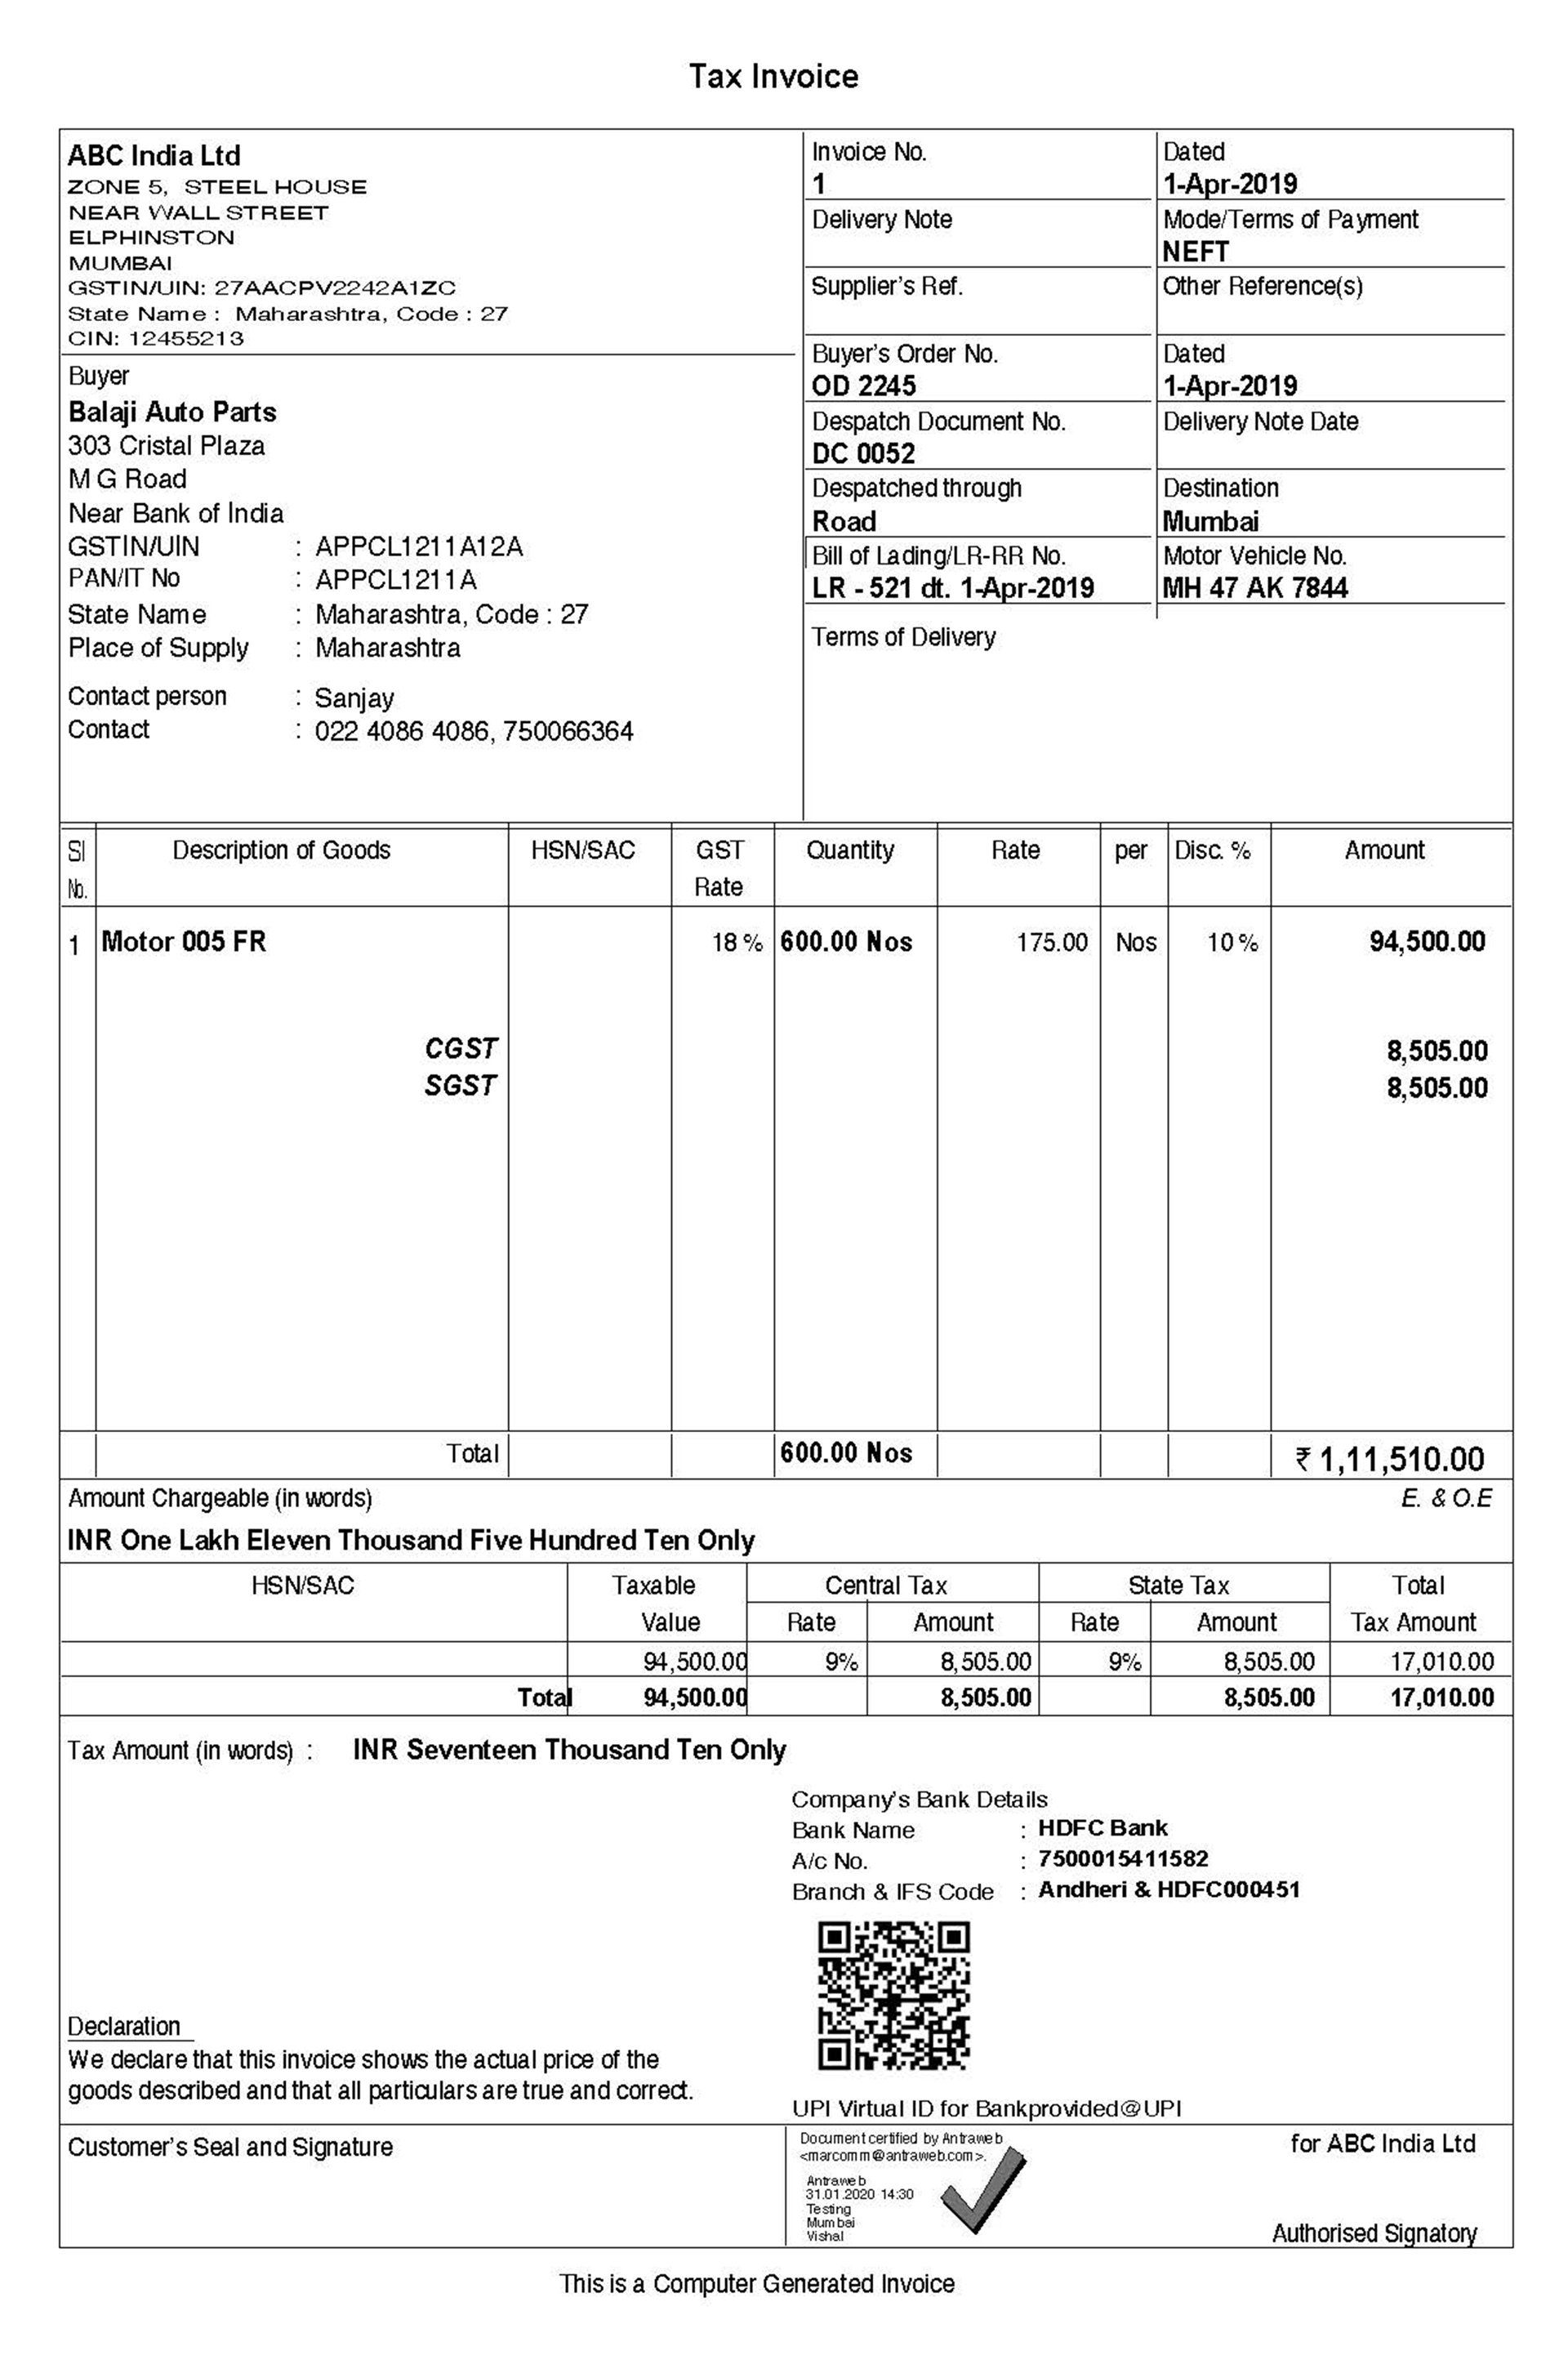


    Image #1:
    Origin: file:/content/Document_advertisement2.png
    Resolution: 0 dpi
    Width: 691 px
    Height: 691 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


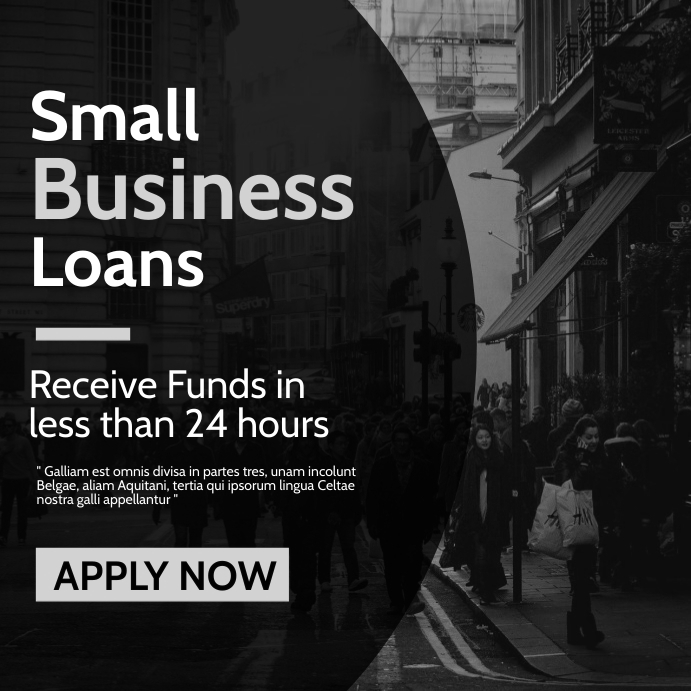


    Image #2:
    Origin: file:/content/Document_advertisement3.png
    Resolution: 72 dpi
    Width: 1080 px
    Height: 1920 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


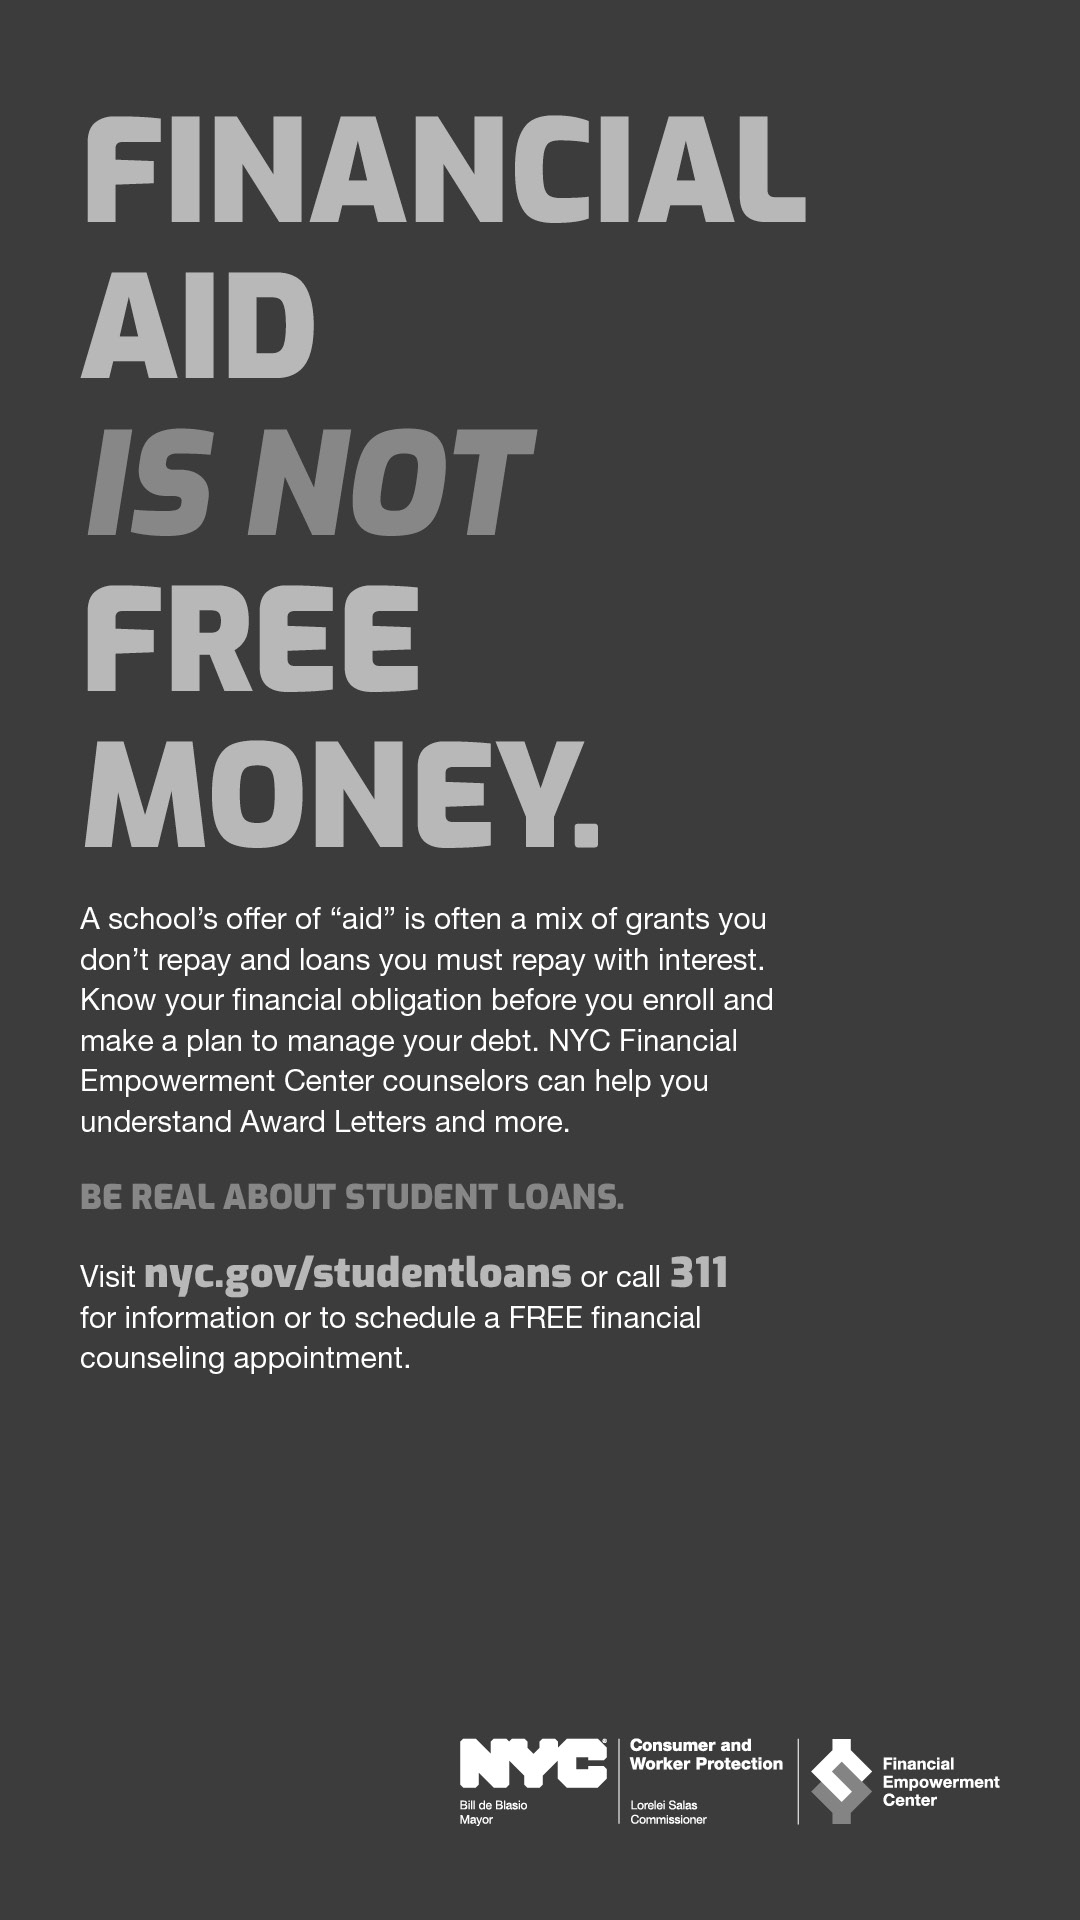


    Image #3:
    Origin: file:/content/Document_email.png
    Resolution: 300 dpi
    Width: 700 px
    Height: 900 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


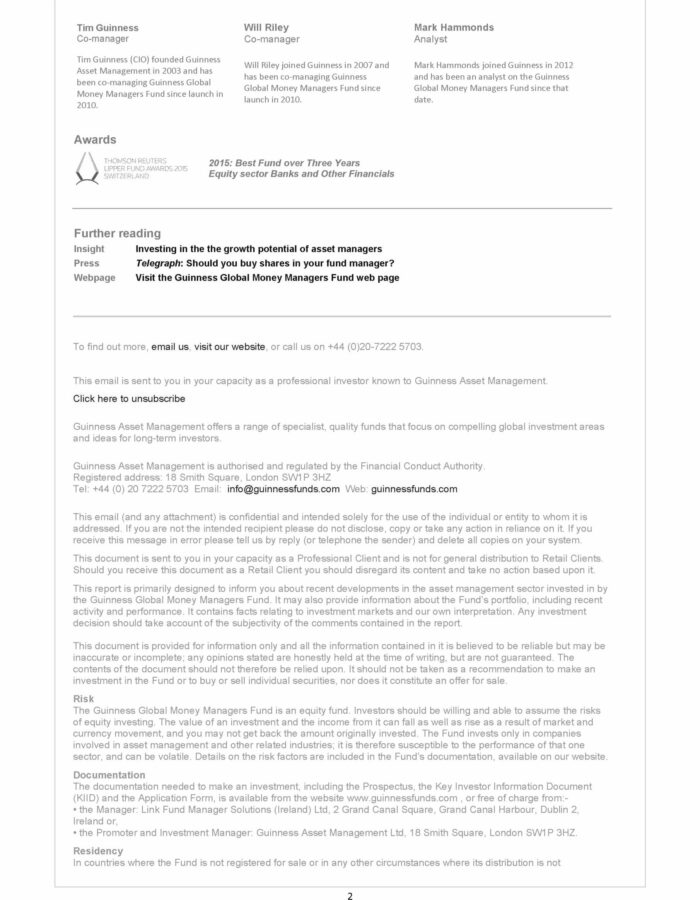


    Image #4:
    Origin: file:/content/Document_budget3.png
    Resolution: 0 dpi
    Width: 612 px
    Height: 792 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


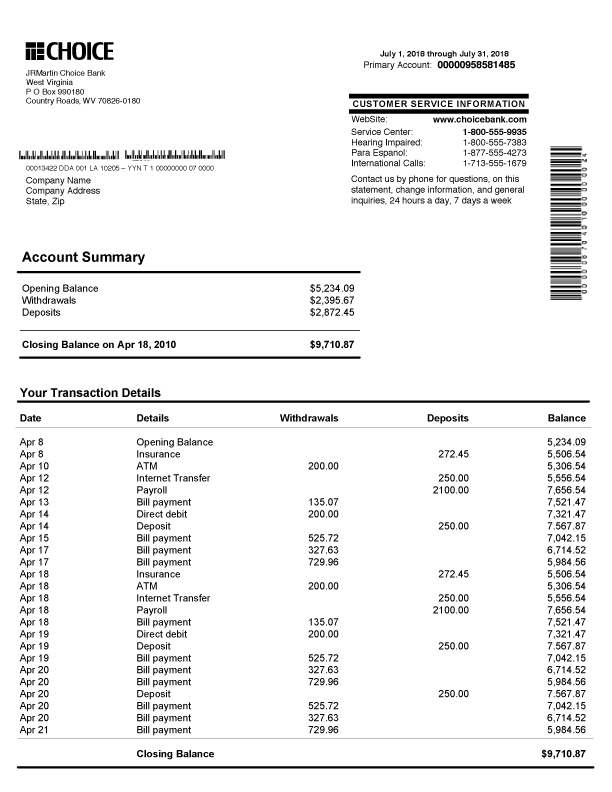

In [17]:
image_df = BinaryToImage().transform(sample_images)
display_images(image_df)

# Define pipeline

In [18]:
from sparkocr.utils import get_vocabulary_dict

binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

doc_class = VisualDocumentClassifierV3() \
    .pretrained("dit_base_finetuned_rvlcdip", "en", "clinical/ocr") \
    .setInputCols(["image"])\
    .setOutputCol("label")

pipeline = PipelineModel(stages=[binary_to_image,
                                 doc_class])

# Call pipeline

In [19]:
results = pipeline.transform(sample_images).cache()

# Show results

In [20]:
results

+--------------------+--------------------+--------------------+-------+-------+-------------+---------+
|               image|                path|    modificationTime| length|pagenum|        label|exception|
+--------------------+--------------------+--------------------+-------+-------+-------------+---------+
|{file:/content/Do...|file:/content/Doc...|2022-09-13 07:06:...|1364836|      0|      invoice|     null|
|{file:/content/Do...|file:/content/Doc...|2022-09-13 07:06:...| 305933|      0|advertisement|     null|
|{file:/content/Do...|file:/content/Doc...|2022-09-13 07:06:...| 239989|      0|advertisement|     null|
|{file:/content/Do...|file:/content/Doc...|2022-09-13 07:12:...|  93146|      0|        email|     null|
|{file:/content/Do...|file:/content/Doc...|2022-09-13 07:11:...|  53850|      0|       budget|     null|
+--------------------+--------------------+--------------------+-------+-------+-------------+---------+

In [23]:
results.select("image", "label")

+--------------------+-------------+
|               image|        label|
+--------------------+-------------+
|{file:/content/Do...|      invoice|
|{file:/content/Do...|advertisement|
|{file:/content/Do...|advertisement|
|{file:/content/Do...|        email|
|{file:/content/Do...|       budget|
+--------------------+-------------+

 
 CLASS: invoice

    Image #0:
    Origin: file:/content/Document_invoice3.png
    Resolution: 0 dpi
    Width: 1920 px
    Height: 2889 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


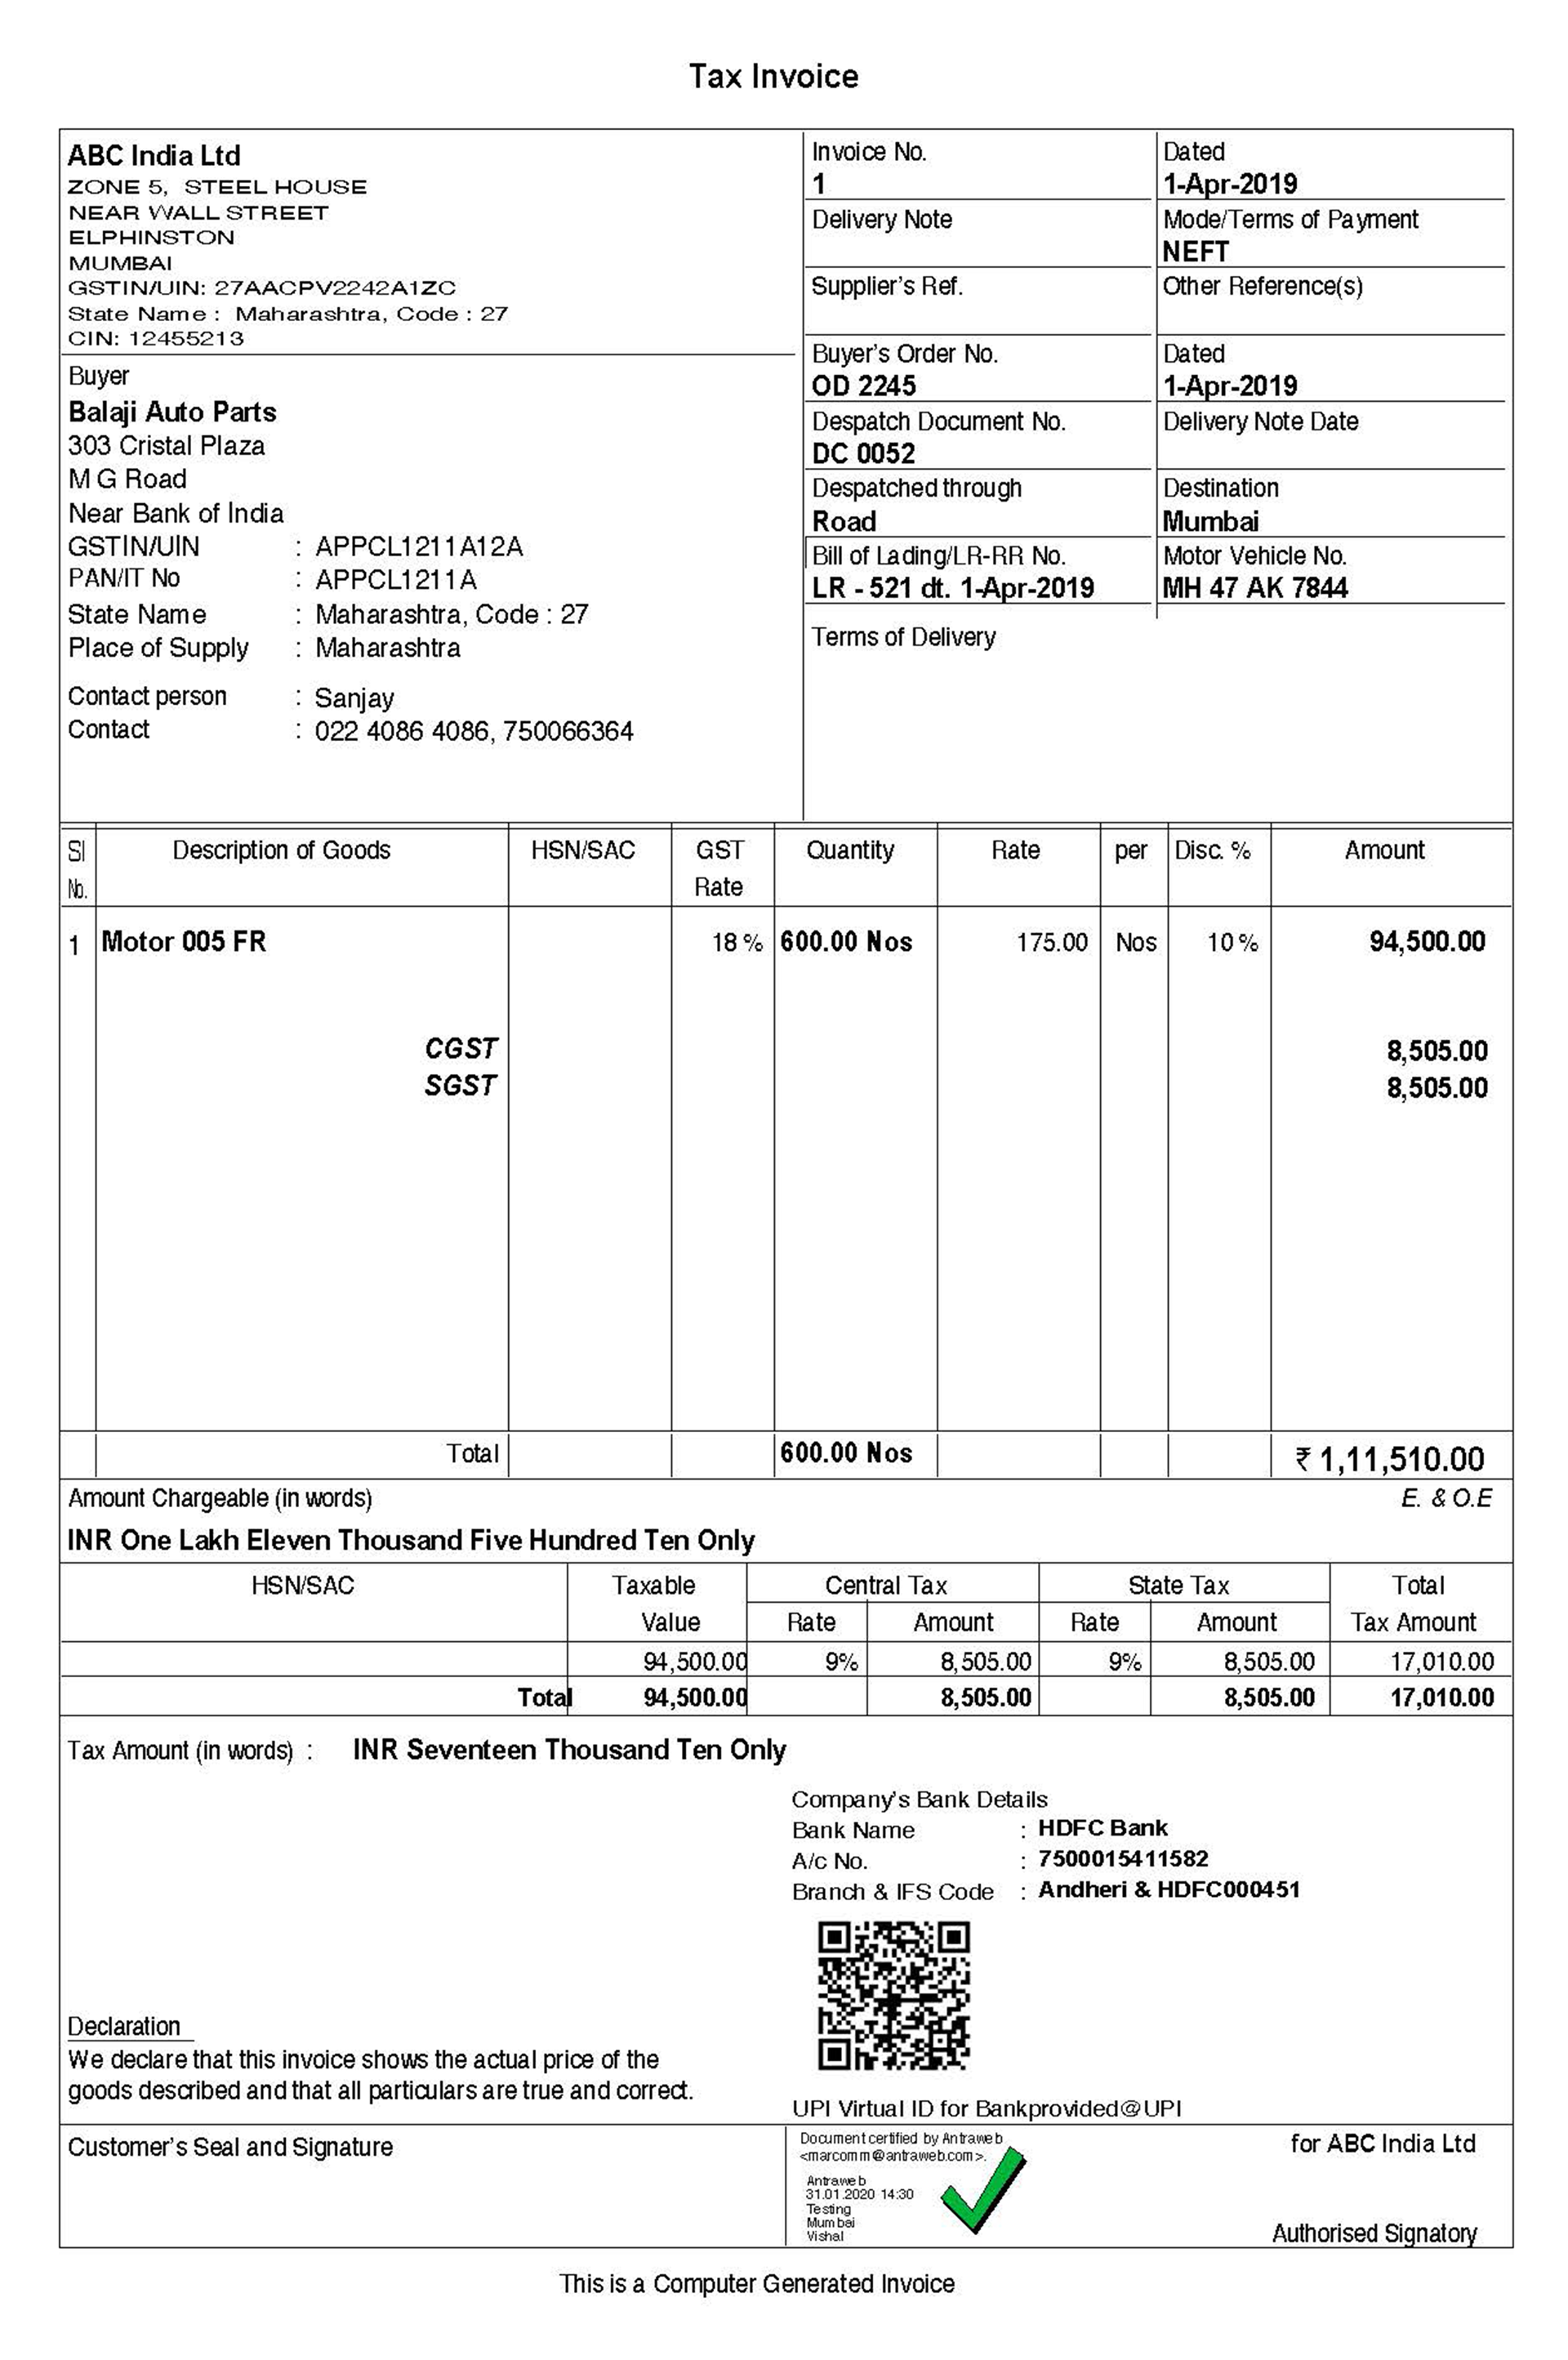

 
 CLASS: email

    Image #0:
    Origin: file:/content/Document_email.png
    Resolution: 300 dpi
    Width: 700 px
    Height: 900 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


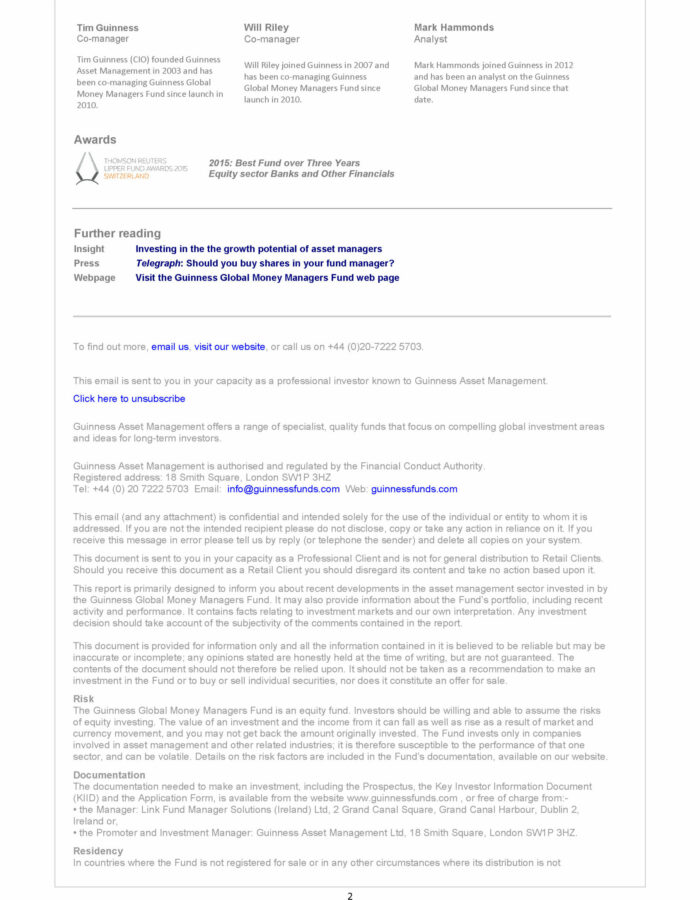

 
 CLASS: budget

    Image #0:
    Origin: file:/content/Document_budget3.png
    Resolution: 0 dpi
    Width: 612 px
    Height: 792 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


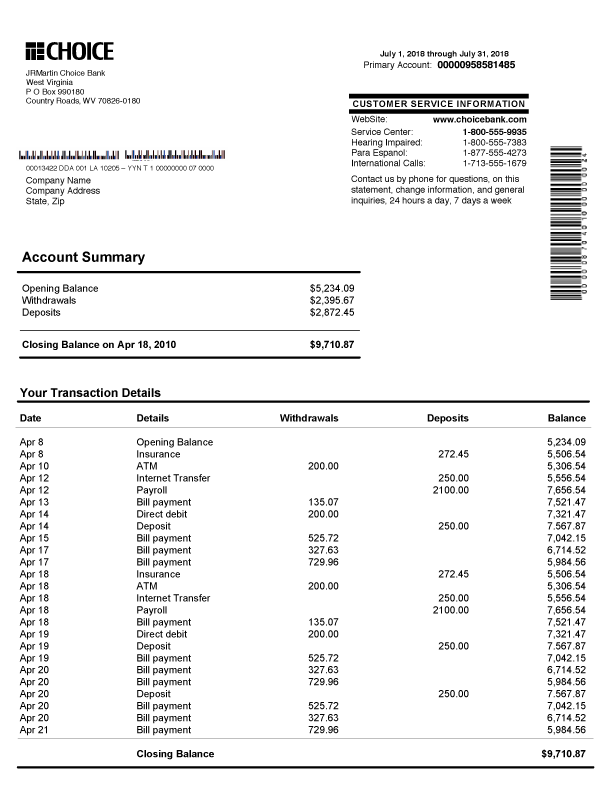

 
 CLASS: advertisement

    Image #0:
    Origin: file:/content/Document_advertisement2.png
    Resolution: 0 dpi
    Width: 691 px
    Height: 691 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


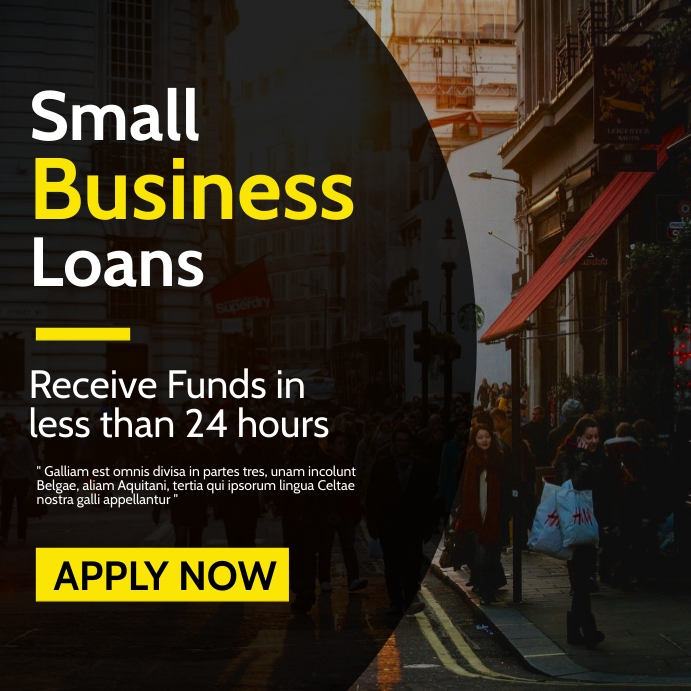

 
 CLASS: advertisement

    Image #0:
    Origin: file:/content/Document_advertisement3.png
    Resolution: 72 dpi
    Width: 1080 px
    Height: 1920 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


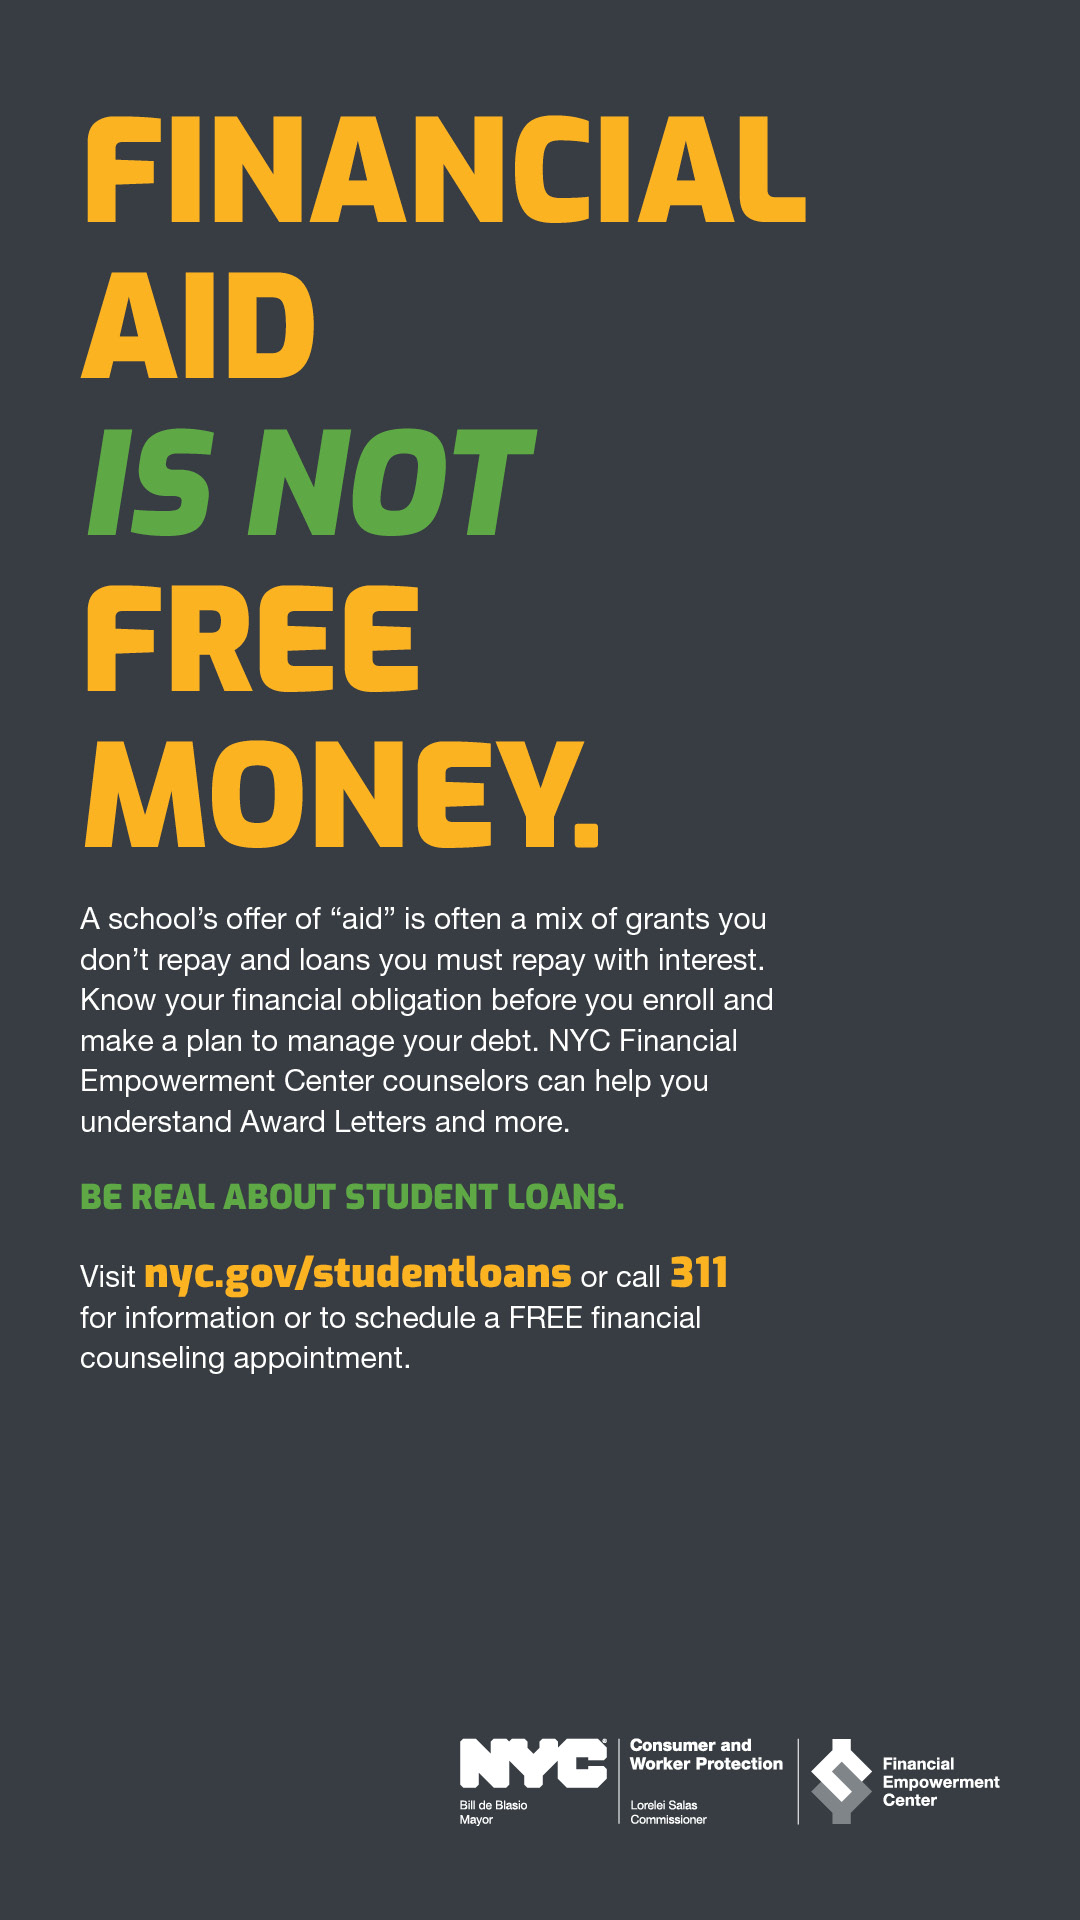

In [38]:
for r in results.distinct().collect():
    print(f"\033[1;32m \n CLASS: {r.label}")
    display_image(r.image)
    
  